In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [20]:
data = pd.read_csv('../data/num_file/hrs_01/p040.csv')

In [21]:
print(data)

                 datetime  count
0     2022-04-21 01:00:00   1033
1     2022-04-21 02:00:00     65
2     2022-04-21 03:00:00      0
3     2022-04-21 04:00:00      0
4     2022-04-21 05:00:00      0
...                   ...    ...
3246  2022-09-03 07:00:00   9741
3247  2022-09-03 08:00:00  19613
3248  2022-09-03 09:00:00  22055
3249  2022-09-03 10:00:00  14644
3250  2022-09-03 11:00:00  12751

[3251 rows x 2 columns]


If there is no people, use NaN.

In [22]:
data.loc[data['count']==0, 'count'] = np.NaN

In [23]:
print(data)

                 datetime    count
0     2022-04-21 01:00:00   1033.0
1     2022-04-21 02:00:00     65.0
2     2022-04-21 03:00:00      NaN
3     2022-04-21 04:00:00      NaN
4     2022-04-21 05:00:00      NaN
...                   ...      ...
3246  2022-09-03 07:00:00   9741.0
3247  2022-09-03 08:00:00  19613.0
3248  2022-09-03 09:00:00  22055.0
3249  2022-09-03 10:00:00  14644.0
3250  2022-09-03 11:00:00  12751.0

[3251 rows x 2 columns]


<Axes: >

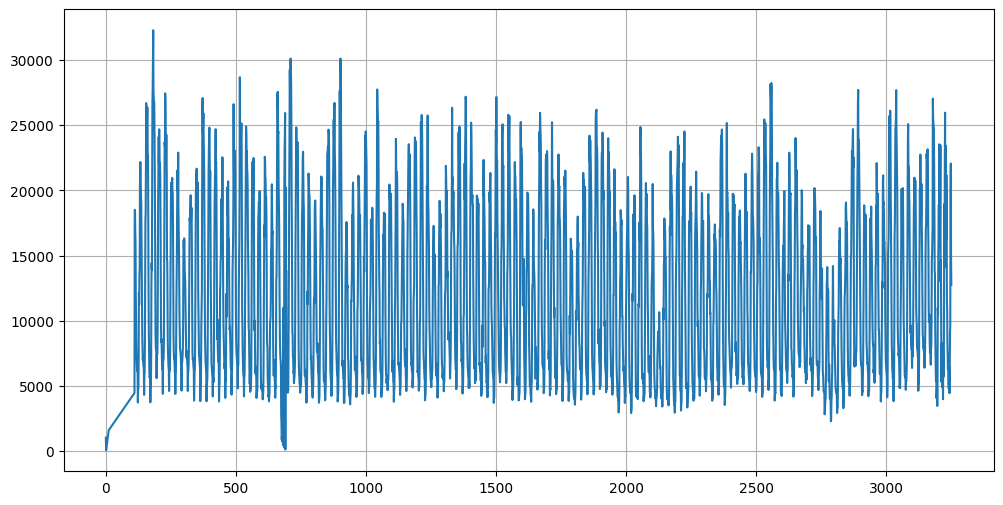

In [24]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

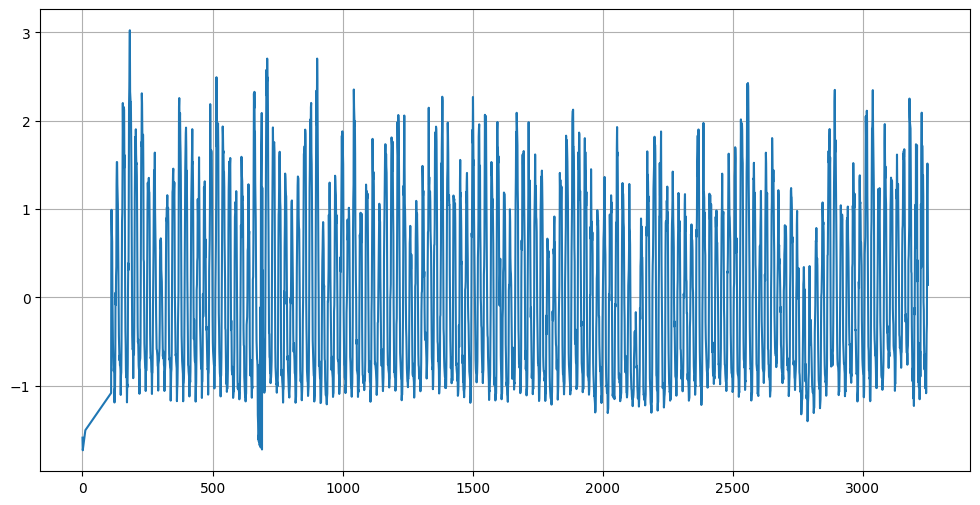

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [26]:
print(data)

                 datetime     count
0     2022-04-21 01:00:00 -1.588140
1     2022-04-21 02:00:00 -1.730996
2     2022-04-21 03:00:00 -1.708284
3     2022-04-21 04:00:00 -1.685572
4     2022-04-21 05:00:00 -1.662859
...                   ...       ...
3246  2022-09-03 07:00:00 -0.303021
3247  2022-09-03 08:00:00  1.153879
3248  2022-09-03 09:00:00  1.514267
3249  2022-09-03 10:00:00  0.420559
3250  2022-09-03 11:00:00  0.141192

[3251 rows x 2 columns]


In [27]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 60

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [28]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [29]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

In [30]:
print(decode_output_data[:, -1, :])

[[-1.29540422]
 [-1.29114977]
 [-1.28689531]
 ...
 [ 1.15387905]
 [ 1.51426713]
 [ 0.42055868]]


## Model

In [31]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [32]:
input_data = Input(shape=(time_step, 1))
x = LSTM(32, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [33]:
model = Model(inputs=input_data, outputs=output_data)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,449 (17.38 KB)

 Non-trainable params: 64 (256.00 B)

In [34]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100


2024-05-03 17:53:31.638954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6856 - mae: 0.6330

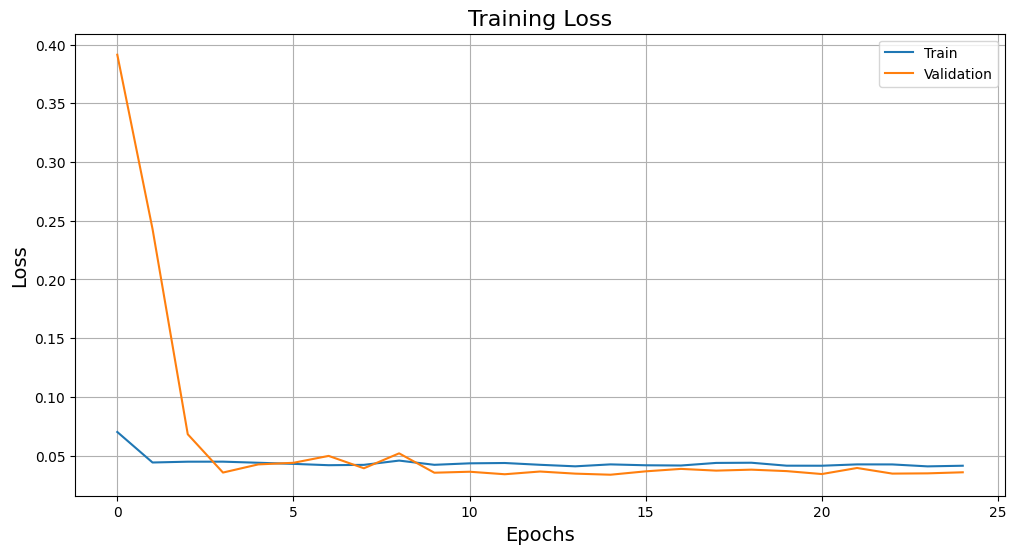

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 0s 1ms/step


In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [ ]:
print(predict_test_data)

[[ 697.63837]
 [ 787.3285 ]
 [ 724.8534 ]
 ...
 [1138.0946 ]
 [1738.8572 ]
 [1730.8611 ]]


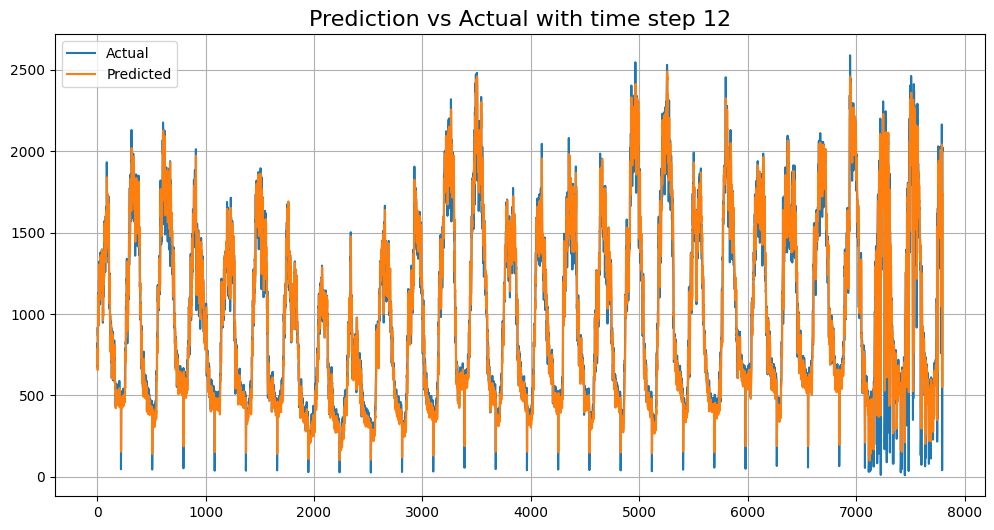

In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.legend(['Actual', 'Predicted'])
plt.title(f'Prediction vs Actual with time step {time_step}')
plt.show()

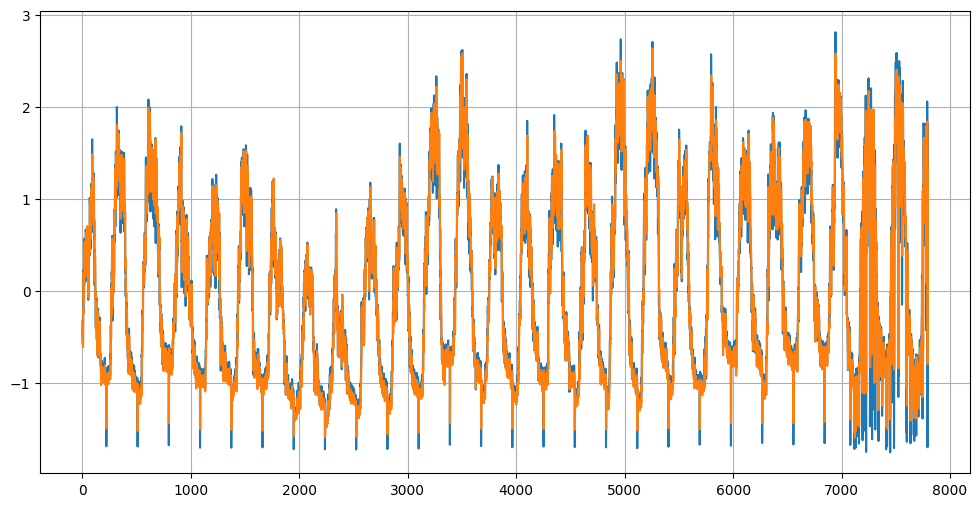

In [ ]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [ ]:
print(predict_test_data)

[[ 697.63837]
 [ 787.3285 ]
 [ 724.8534 ]
 ...
 [1138.0946 ]
 [1738.8572 ]
 [1730.8611 ]]


In [ ]:
print(decode_output_test_data)

[[ 818.]
 [ 735.]
 [ 770.]
 ...
 [1913.]
 [2024.]
 [2006.]]


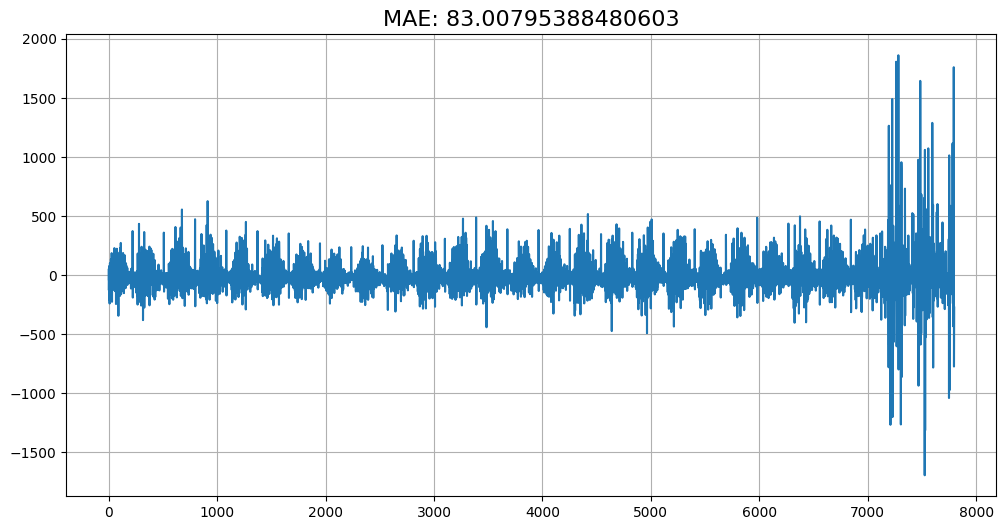

In [ ]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

83.00795388480603
